In [269]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pysensors as ps

In [270]:
faces = datasets.fetch_olivetti_faces(shuffle=True)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

Number of samples: 400
Number of features (sensors): 4096


In [271]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

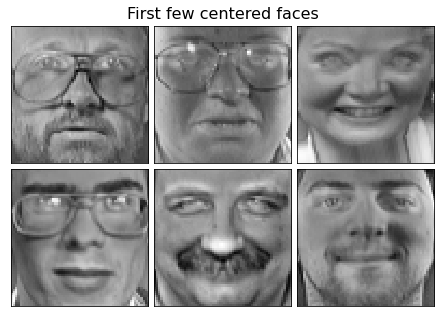

In [272]:
plot_gallery("First few centered faces", X[:n_components])

In [273]:
#Find all sensor locations using built in QR optimizer
max_const_sensors = 230
n_sensors = 100
n_const_sensors = 5
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(optimizer=optimizer, n_sensors=n_sensors)
model.fit(X)

all_sensors = model.get_all_sensors()
print(all_sensors)

[4032  384 4092 ... 2165 2561 1802]


In [274]:
#Define Constrained indices
a = np.unravel_index(all_sensors, (64,64))
print(a)
a_array = np.transpose(a)
print(a_array.shape)
#idx = np.ravel_multi_index(a, (64,64))
#print(idx)
constrained_sensorsx = []
constrained_sensorsy = []
for i in range(n_features):
    if a[0][i] < 10 and a[1][i] > 40:  # x<10 and y>40
        constrained_sensorsy.append(a[0][i])
        constrained_sensorsx.append(a[1][i])

constrained_sensorsx = np.array(constrained_sensorsx)
constrained_sensorsy = np.array(constrained_sensorsy)

constrained_sensors_array = np.stack((constrained_sensorsy, constrained_sensorsx), axis=1)
constrained_sensors_tuple = np.transpose(constrained_sensors_array)


#print(constrained_sensors_tuple)
#print(len(constrained_sensors_tuple))
idx_constrained = np.ravel_multi_index(constrained_sensors_tuple, (64,64))

#print(len(idx_constrained))
#print(constrained_sensorsx)
#print(constrained_sensorsy)
#print(idx_constrained)
print(np.sort(idx_constrained[:]))
all_sorted = np.sort(all_sensors)
#print(all_sorted)
idx = np.arange(all_sorted.shape[0])
#all_sorted[idx_constrained] = 0

(array([63,  6, 63, ..., 33, 40, 28]), array([ 0,  0, 60, ..., 53,  1, 10]))
(4096, 2)
[ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 361 362 363 364 365 366 367 368 369 370 371
 372 373 374 375 376 377 378 379 380 381 382 383 425 426 427 428 429 430
 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 489
 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 

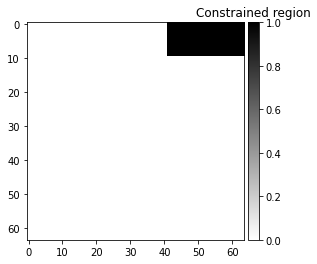

In [275]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot()
#Plot constrained space
img = np.zeros(n_features)
img[idx_constrained] = 1
im = plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.title('Constrained region');

In [276]:
#New class for constrained sensor placement
from pysensors.optimizers._qr import QR
class GQR(QR):
    """
    General QR optimizer for sensor selection.
    Ranks sensors in descending order of "importance" based on
    reconstruction performance. 

    See the following reference for more information

        Manohar, Krithika, et al.
        "Data-driven sparse sensor placement for reconstruction:
        Demonstrating the benefits of exploiting known patterns."
        IEEE Control Systems Magazine 38.3 (2018): 63-86.
    """
    def __init__(self):
        """
        Attributes
        ----------
        pivots_ : np.ndarray, shape [n_features]
            Ranked list of sensor locations.
        """
        self.pivots_ = None
    
    def fit(
        self,
        basis_matrix, idx_constrained, const_sensors,
    ):
        """
        Parameters
        ----------
        basis_matrix: np.ndarray, shape [n_features, n_samples]
            Matrix whose columns are the basis vectors in which to
            represent the measurement data.
        optimizer_kws: dictionary, optional
            Keyword arguments to be passed to the qr method.

        Returns
        -------
        self: a fitted :class:`pysensors.optimizers.CCQR` instance
        """

        n, m = basis_matrix.shape  # We transpose basis_matrix below
    
        # Initialize helper variables
        R = basis_matrix.conj().T.copy()
        #print(R.shape)
        p = np.arange(n)
        #print(p)
        k = min(m, n)
        
      
        for j in range(k):
            r = R[j:, j:]
            # Norm of each column
            dlens = np.sqrt(np.sum(np.abs(r) ** 2, axis=0))
            
            dlens_updated = f_region(idx_constrained,dlens,p,j, const_sensors)
            
            # Choose pivot
            i_piv = np.argmax(dlens_updated)
            #print(i_piv)
            
            
            dlen = dlens_updated[i_piv]
            
            if dlen > 0:
                u = r[:, i_piv] / dlen
                u[0] += np.sign(u[0]) + (u[0] == 0)
                u /= np.sqrt(abs(u[0]))
            else:
                u = r[:, i_piv]
                u[0] = np.sqrt(2)
                
            # Track column pivots
            i_piv += j # true permutation index is i_piv shifted by the iteration counter j
            print(i_piv) # Niharika's debugging line
            p[[j, i_piv]] = p[[i_piv, j]]
            print(p)


            # Switch columns
            R[:, [j, i_piv]] = R[:, [i_piv, j]]
            
            # Apply reflector
            R[j:, j:] -= np.outer(u, np.dot(u, R[j:, j:]))
            R[j + 1 :, j] = 0
            

        self.pivots_ = p
    

        return self
#function for mapping sensor locations with constraints
def f_region(lin_idx, dlens, piv, j, const_sensors): 
    #num_sensors should be fixed for each custom constraint (for now)
    #num_sensors must be <= size of constraint region
    """
    Function for mapping constrained sensor locations with the QR procedure.
    
    Parameters
        ----------
        lin_idx: np.ndarray, shape [No. of constrained locations]
            Array which contains the constrained locations mapped on the grid.
        dlens: np.ndarray, shape [Variable based on j]
            Array which contains the norm of columns of basis matrix.
         num_sensors: int, 
            Number of sensors to be placed in the constrained area.
        j: int,
            Iterative variable in the QR algorithm.

        Returns
        -------
        dlens : np.darray, shape [Variable based on j] with constraints mapped into it. 
    """
    if j < const_sensors: # force sensors into constraint region
        #idx = np.arange(dlens.shape[0])        
        #dlens[np.delete(idx, lin_idx)] = 0
        
        didx = np.isin(piv[j:],lin_idx,invert=True)
        dlens[didx] = 0
        
    # otherwise don't do anything
    #else: 
         #dlens[lin_idx-j] = 0
    return dlens



In [277]:

optimizer1 = GQR()
model1 = ps.SSPOR(optimizer = optimizer1, n_sensors = n_sensors)
model1.fit(X, quiet=True, prefit_basis=False, seed=None, idx_constrained = idx_constrained, const_sensors = n_const_sensors)

447
[ 447    1    2 ... 4093 4094 4095]
493
[ 447  493    2 ... 4093 4094 4095]
625
[ 447  493  625 ... 4093 4094 4095]
59
[ 447  493  625 ... 4093 4094 4095]
635
[ 447  493  625 ... 4093 4094 4095]
4032
[ 447  493  625 ... 4093 4094 4095]
320
[ 447  493  625 ... 4093 4094 4095]
4039
[ 447  493  625 ... 4093 4094 4095]
4092
[ 447  493  625 ... 4093 4094 4095]
2204
[ 447  493  625 ... 4093 4094 4095]
878
[ 447  493  625 ... 4093 4094 4095]
1088
[ 447  493  625 ... 4093 4094 4095]
3779
[ 447  493  625 ... 4093 4094 4095]
3093
[ 447  493  625 ... 4093 4094 4095]
4087
[ 447  493  625 ... 4093 4094 4095]
2624
[ 447  493  625 ... 4093 4094 4095]
2331
[ 447  493  625 ... 4093 4094 4095]
2783
[ 447  493  625 ... 4093 4094 4095]
4043
[ 447  493  625 ... 4093 4094 4095]
3456
[ 447  493  625 ... 4093 4094 4095]
2901
[ 447  493  625 ... 4093 4094 4095]
3039
[ 447  493  625 ... 4093 4094 4095]
1023
[ 447  493  625 ... 4093 4094 4095]
1224
[ 447  493  625 ... 4093 4094 4095]
1052
[ 447  493  625 ...

SSPOR(basis=Identity(n_basis_modes=400), n_sensors=100, optimizer=GQR())

In [278]:
all_sensors1 = model1.get_all_sensors()
print(all_sensors1[:230])

print(np.array_equal(np.sort(all_sensors),np.sort(all_sensors1)))

[ 447  493  625   59  635 4032  320 4039 4092 2204  878 1088 3779 3093
 4087 2624 2331 2783 4043 3456 2901 3039 1023 1224 1052 3164 2011 4031
 1188 4037    4 3358 2815 2880 2648 1100 2210 2909 1535 3643 3550  718
 1728 1212 4089 4084 2399 1155 3654 4049 2457 1178 4034  969 3395 1140
 2797 2367 2048 2987 3327  768  584 2341 1138  898 2656 1055 1037 3179
 4066 1035 1217 2022 3890 3075 3220  859 3323  761 3656 2897 2214 1109
 1603 2470 3744 3652 1818 2264 1406  726 3236 1068 1112 2304  592 3776
 1210 2137 2981 2525 3107  925 1094 2077 2793 4035 4041 4091 2626 1021
   63 1434 2493 3583 3031 3026 2089 1344 1126 2197 2705 4045 1250 3586
 1270 3845 1102  944 1943  749    2 2111  766 3704 2774 3517 3351 1071
 3729 2333  948 1446 3201  994 3632  806 2028  755 1041 2849 3334 2148
  773 2905 3129 3225 2345  787 2607 3086  374 3836    0 1043  513 3844
 2071 1163 1244 3461  976 4076 1665 3306  643 1089  960 3846  508 1016
 3958  910 1596 2327  862 1956 1010 3905 1895 2778  857 2964 3071 1277
 3912 

In [279]:
xmin = 40
xmax = 64
ymin = 0
ymax = 10

[ 447  493  625   59  635 4032  320 4039 4092 2204  878 1088 3779 3093
 4087 2624 2331 2783 4043 3456 2901 3039 1023 1224 1052 3164 2011 4031
 1188 4037    4 3358 2815 2880 2648 1100 2210 2909 1535 3643 3550  718
 1728 1212 4089 4084 2399 1155 3654 4049 2457 1178 4034  969 3395 1140
 2797 2367 2048 2987 3327  768  584 2341 1138  898 2656 1055 1037 3179
 4066 1035 1217 2022 3890 3075 3220  859 3323  761 3656 2897 2214 1109
 1603 2470 3744 3652 1818 2264 1406  726 3236 1068 1112 2304  592 3776
 1210 2137]


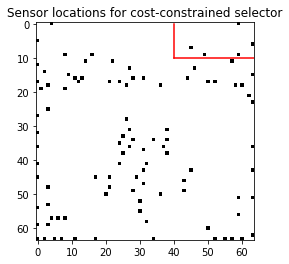

In [280]:
top_sensors = model1.get_selected_sensors()
print(top_sensors)
img = np.zeros(n_features)
img[top_sensors] = 16
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
plt.title('Sensor locations for cost-constrained selector');
    

In [281]:
print(n_sensors)
print(idx_constrained.shape)

100
(230,)
